# Imports

In [1]:
# from sksurv.metrics          import concordance_index_censored, concordance_index_ipcw
# from mpl_toolkits.axes_grid1 import ImageGrid
# from matplotlib.colors       import LinearSegmentedColormap
# from skimage.transform       import resize
# from plottify                import autosize
# from sklearn                 import metrics
# from PIL                     import Image
# from adjustText              import adjust_text
# from scipy.cluster           import hierarchy
from lifelines 				 import CoxPHFitter
# import statsmodels.api   as sm
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import pandas            as pd
# import scanpy            as sc
# import scipy.stats
import matplotlib
# import anndata
# import random
# import fastcluster
import sklearn
import copy
# import umap
# import h5py
import shap
import sys
import os

# Workspace path.
main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'

sys.path.append(main_path)
# from models.visualization.survival import save_fold_KMs
# from models.visualization.forest_plots import report_forest_plot_cph, summary_cox_forest_plots
from models.clustering.cox_proportional_hazard_regression_leiden_clusters import *
from models.evaluation.folds import load_existing_split
from models.visualization.attention_maps import *
from models.clustering.data_processing import *
# from data_manipulation.data import Data


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


2024-09-13 13:14:08.756781: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12


# Plot figures

In [27]:
from lifelines.plotting import add_at_risk_counts
# Survival libs.
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

def plot_KM_high_low(high_risk_df, low_risk_df, ax_title, ax, event_ind_field, event_data_field, max_months=None):
    

    fontsize_title  = 15
    fontsize_labels = 11
    fontsize_ticks  = 11
    fontsize_legend = 10
    l_markerscale   = 8
    l_box_w         = 3
    


    kmf_l = KaplanMeierFitter(label='Low-Risk')
    kmf_l.fit(low_risk_df[event_data_field].astype(float),  event_observed=low_risk_df[event_ind_field].astype(float))
    kmf_h = KaplanMeierFitter(label='High-Risk')
    kmf_h.fit(high_risk_df[event_data_field].astype(float), event_observed=high_risk_df[event_ind_field].astype(float))

    kmf_l.plot_survival_function(show_censors=True, ci_show=True, ax=ax)
    kmf_h.plot_survival_function(show_censors=True, ci_show=True, ax=ax)

    ax.set_title(ax_title)
    ax.set_ylim([0.0,1.10])
    ax.patch.set_linewidth(1)
    if max_months is not None:
        ax.set_xlim([0.0, max_months])
    
    for ticks in [ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()]:
        for tick in ticks:
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label1.set_fontweight('bold')

    
    ax.set_title(ax_title, fontsize=fontsize_title, fontweight='bold', y=1.02)

    ax.set_xlabel('Time (Month)',         fontsize=fontsize_labels)
    ax.set_ylabel('Survival Probability', fontsize=fontsize_labels)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)

    legend = ax.legend(loc='best', markerscale=l_markerscale, title='Risk Group', prop={'size': fontsize_legend})
    legend.get_title().set_fontsize(fontsize_legend)
    legend.get_frame().set_linewidth(l_box_w)
    for line in legend.get_lines():
        line.set_linewidth(l_markerscale)
    
    add_at_risk_counts(kmf_l, kmf_h, ax=ax, ypos= -0.8)
    plt.tight_layout()


def plot_k_fold_cv_KM(high_risk, low_risk, title, max_months, event_ind_field, event_data_field, file_path=None):
    results = logrank_test(high_risk[event_data_field].astype(float), low_risk[event_data_field].astype(float), event_observed_A=high_risk[event_ind_field].astype(float), event_observed_B=low_risk[event_ind_field].astype(float))
    title_add = 'P-Value: %.2E ' % (Decimal(results.p_value))
    mosaic = '''A'''
    fig = plt.figure(figsize=(12,6.6), constrained_layout=True)
    ax_dict = fig.subplot_mosaic(mosaic)
    plot_KM_high_low(high_risk, low_risk, ax_title=title + title_add, ax=ax_dict['A'], event_ind_field=event_ind_field, event_data_field=event_data_field, max_months=max_months)
    plt.savefig(file_path, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    return results.p_value

def save_fold_KMs(train_risk, risk_groups, additional_risk, resolution, groupby, cis, event_ind_field, event_data_field, max_months, cox_cluster_path):
    train_cindex = np.round(cis[0],2)
    title = 'Leiden %s Train Set \n' % (resolution)
    file_path=os.path.join(cox_cluster_path, 'KM_%s_train.jpg' % (str(groupby).replace('.', 'p')))
    train_pval = plot_k_fold_cv_KM(train_risk[1], train_risk[0], title=title, max_months=max_months, event_ind_field=event_ind_field, event_data_field=event_data_field, file_path=file_path)
   
    test_cindex = np.round(cis[1],2)
    # title = 'Leiden %s\nC-Index Test: %s \n' % (resolution, test_cindex)
    title = 'Leiden %s Test Set \n' % (resolution)
    file_path=os.path.join(cox_cluster_path, 'KM_%s_test.jpg' % (str(groupby).replace('.', 'p')))
    test_pval = plot_k_fold_cv_KM(risk_groups[1], risk_groups[0], title=title, max_months=max_months, event_ind_field=event_ind_field, event_data_field=event_data_field, file_path=file_path)

    additional_pval = None
    
    additional_cindex = np.round(cis[2],2)
    # title = 'Leiden %s\nC-Index Additional (TCGA): %s \n' % (resolution, additional_cindex)
    title = 'Leiden %s Additional (TCGA) \n' % (resolution)
    file_path=os.path.join(cox_cluster_path, 'KM_%s_additional.jpg' % (str(groupby).replace('.', 'p')))
    additional_pval = plot_k_fold_cv_KM(additional_risk[1], additional_risk[0], title=title, max_months=max_months, event_ind_field=event_ind_field, event_data_field=event_data_field, file_path=file_path)

    return train_pval, test_pval, additional_pval

# Divide group into X buckets.
def get_high_low_risks(predictions, datas, fold, matching_field, q_buckets=2):
	labels_buckets = list(range(q_buckets))
	high_lows = list()
	for index, set_data in enumerate(zip(datas, predictions)):
		data, prediction = set_data
		if data[0] is None:
			high_lows.append((None, None, None))
			continue
		current_hazard                     = data[0].copy(deep=True)
		current_hazard['hazard']           = prediction[0]
		if index == 0:
			# median_cutoff is the median hazard value of the train set
			median_cutoff = current_hazard['hazard'].median()
		# If the hazard is higher than the median, it is high risk, otherwise it is low risk.
		current_hazard['h_bin']            = (current_hazard['hazard']>median_cutoff)*1
		current_hazard['h_bin_%s' % fold]  = (current_hazard['hazard']>median_cutoff)*1
		current_low_risk_slides            = current_hazard[current_hazard['h_bin']==labels_buckets[0]][matching_field].values
		current_high_risk_slides           = current_hazard[current_hazard['h_bin']==labels_buckets[1]][matching_field].values

		high_risk_df = current_hazard[current_hazard[matching_field].isin(current_high_risk_slides)].copy(deep=True)
		low_risk_df  = current_hazard[current_hazard[matching_field].isin(current_low_risk_slides)].copy(deep=True)
		high_lows.append((high_risk_df, low_risk_df, current_hazard))
	return high_lows


# Combine Risk Groups over the folds. In the case of additional dataset, mayority vote over folds.
def combine_risk_groups(train_risk, test_risk, additional_risk, high_lows, fold, num_folds, matching_field, event_ind_field, event_data_field):
	# For test set, combine the risk groups.
	train_risk[1] = pd.concat([train_risk[1], high_lows[0][1][[matching_field, event_data_field, event_ind_field]]], ignore_index=True)
	train_risk[0] = pd.concat([train_risk[0], high_lows[0][0][[matching_field, event_data_field, event_ind_field]]], ignore_index=True)



	test_risk[1] = pd.concat([test_risk[1], high_lows[1][1]], ignore_index=True)
	test_risk[0] = pd.concat([test_risk[0], high_lows[1][0]], ignore_index=True)

	# For additional dataset, combine the risk groups.
	if high_lows[2][2] is not None:
		additional_risk[1] = pd.concat([additional_risk[1], high_lows[2][1]], ignore_index=True)
		additional_risk[0] = pd.concat([additional_risk[0], high_lows[2][0]], ignore_index= True)
	else:
		additional_risk = None
	return train_risk, test_risk, additional_risk

In [80]:
# Plot SHAP figure.
def plot_shap_figure(shap_cv, order, total_order, text1, text2, plot_size=(25,20), fontsize_labels=24, fontsize_ticks=22, offset=150, cmap_bar=sns.diverging_palette(250, 20, as_cmap=True)):
	text = text1 + ''.join([' ']*(offset-len(text1+text2))) + text2

	sns.set_theme(style='white')
	shap.plots.beeswarm(shap_cv, max_display=len(order)+1, order=total_order,
						color_bar_label='Histomorpholical Phenotype Cluster (HPC)\n Contribution',
						color=cmap_bar, plot_size=plot_size, show=False)
	figure = plt.gcf()
	figure.axes[0].set_xlabel(text, fontweight='bold', fontsize=fontsize_labels)
	figure.axes[1].set_ylabel('Histomorpholical Phenotype Cluster (HPC)\n Contribution', fontweight='bold', fontsize=fontsize_labels)
	for ax in [figure.axes[0], figure.axes[1]]:
		for tick in ax.xaxis.get_major_ticks():
			tick.label1.set_fontweight('bold')
			tick.label2.set_fontweight('bold')
			tick.label1.set_fontsize(fontsize_ticks)
			tick.label2.set_fontsize(fontsize_ticks)
		for tick in ax.yaxis.get_major_ticks():
			tick.label1.set_fontweight('bold')
			tick.label2.set_fontweight('bold')
			tick.label1.set_fontsize(fontsize_ticks)
			tick.label2.set_fontsize(fontsize_ticks)
		for axis in ['top','bottom','left','right']:
			ax.spines[axis].set_linewidth(4)
	plt.show()


# Plot SHAP figure.
def plot_shap_figure_simple(shap_cv, text1='', text2='', plot_size=(25,20), fontsize_labels=24, fontsize_ticks=22, offset=150, cmap_bar=sns.diverging_palette(250, 20, as_cmap=True)):
	text = text1 + ''.join([' ']*(offset-len(text1+text2))) + text2

	sns.set_theme(style='white')
	shap.plots.beeswarm(shap_cv, max_display=15,
						color_bar_label='Histomorpholical Phenotype Cluster (HPC)\n Contribution',
						color=cmap_bar, plot_size=plot_size, show=False)
	figure = plt.gcf()
	figure.axes[0].set_xlabel(text, fontweight='bold', fontsize=fontsize_labels)
	figure.axes[1].set_ylabel('Histomorpholical Phenotype Cluster (HPC)\n Contribution', fontweight='bold', fontsize=fontsize_labels)
	for ax in [figure.axes[0], figure.axes[1]]:
		for tick in ax.xaxis.get_major_ticks():
			tick.label1.set_fontweight('bold')
			tick.label2.set_fontweight('bold')
			tick.label1.set_fontsize(fontsize_ticks)
			tick.label2.set_fontsize(fontsize_ticks)
		for tick in ax.yaxis.get_major_ticks():
			tick.label1.set_fontweight('bold')
			tick.label2.set_fontweight('bold')
			tick.label1.set_fontsize(fontsize_ticks)
			tick.label2.set_fontsize(fontsize_ticks)
		for axis in ['top','bottom','left','right']:
			ax.spines[axis].set_linewidth(4)
	plt.show()

def plot_shap_decision(shap_base_values, shap_values, dataset_samples_features, low_risk_ind, high_risk_ind, num_features, show_legend, text, fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w, xlim=None):

    if low_risk_ind is None:
        risk_ind = high_risk_ind
    elif high_risk_ind is None:
        risk_ind = low_risk_ind
    else:
        risk_ind = np.concatenate([low_risk_ind.values, high_risk_ind.values])

    # Legend handling.
    if show_legend and low_risk_ind is not None and high_risk_ind is not None:
        legend_labels = ['Low Risk' for s in range(low_risk_ind.values.shape[0])]
        legend_labels.extend(['High Risk' for s in range(high_risk_ind.values.shape[0])])
    else:
        legend_labels = None
    # Number of HPCs to display
    if num_features == 'all':
        feature_display_range = slice(None, None, -1)
    else:
        feature_display_range = slice(-1, -num_features, -1)

    shap_base_plot = [shap_base_values[risk_ind[0]]]
    shap_cv_values = np.array(shap_values[risk_ind[0]].reshape((1,-1)))
    # data_values    = np.array(dataset_samples_features.loc[risk_ind[0]].values.reshape((1,-1)))

    for ind in risk_ind[1:]:        
        shap_base_plot.append(shap_base_values[ind])
        shap_cv_values = np.concatenate([shap_cv_values, shap_values[ind].reshape((1,-1))])
        # data_values    = np.concatenate([data_values, dataset_samples_features.loc[ind].values.reshape((1,-1))])

    # SHAP decision plot.
    shap.decision_plot(base_value=np.mean(shap_base_plot), shap_values=shap_cv_values, features=dataset_samples_features.loc[risk_ind], xlim=xlim,
                    feature_order='importance', feature_display_range=feature_display_range, show=False, legend_labels=legend_labels, legend_location='lower right')

    # Ascetic fixes.
    figure = plt.gcf()
    # set color palette
    plt.set_cmap('Set1')
    figure.axes[0].set_xlabel(text, fontweight='bold', fontsize=fontsize_labels)
    figure.axes[0].set_ylabel('Histomorpholical Phenotype Cluster (HPC)', fontweight='bold', fontsize=fontsize_labels)
    for ax in [figure.axes[0]]:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontweight('bold')
            tick.label2.set_fontweight('bold')
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label2.set_fontsize(fontsize_ticks)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontweight('bold')
            tick.label2.set_fontweight('bold')
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label2.set_fontsize(fontsize_ticks)
        for axis in ['bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
    
    # Legend for High/Low risk group.
    if show_legend and low_risk_ind is not None and high_risk_ind is not None:
        legend = figure.axes[0].legend_
        new_handles = [legend.legend_handles[0], legend.legend_handles[-1]]
        new_texts   = [legend.get_texts()[0]._text, legend.get_texts()[-1]._text]
        map_dict = dict()
        for handle, text in zip(legend.legend_handles, legend.get_texts()):
            map_dict[handle._label] = text._text

        legend.remove()
        legend = figure.axes[0].legend(new_handles, new_texts, loc='lower right')
        legend.get_frame().set_linewidth(l_box_w)
        for i, handler in enumerate(legend.legend_handles):
            handler.set_linewidth(5)
            handler.set_color('Blue')
            if i!=0:
                handler.set_color('Red')

        for text in legend.get_texts():
            text.set_size(fontsize_legend)
            text.set_fontweight('bold')

        # Re-color lines for High/Low risk group.
        continuous_lines = [child for child in figure.axes[0]._children if child._linestyle == '-' and len(child._x) > 2]
        i = 0 
        for child in continuous_lines:
            risk_name = map_dict[child._label]
            if risk_name == 'Low Risk':
                child.set_color('Blue')
            elif risk_name == 'High Risk':
                child.set_color('Red')
            i+=1
    else:
        annotations_val  = [child for child in figure.axes[0]._children if not isinstance(child, matplotlib.lines.Line2D)]
        for child in annotations_val:
            orig_fontsize = child._fontproperties._size
            child.set_fontweight('bold')
            child.set_size(orig_fontsize*1.1)

    plt.show()

    global_xlim = figure.axes[0].get_xlim()
    return global_xlim


## Variables

In [3]:
# Resolution and fold for the tile clustering and slide representations.
resolution     = '2p0'
fold_number    = 4
groupby        = 'leiden_%s' % resolution

# Folder run.
dataset     = 'Meso'
additional_dataset = 'TCGA_MESO'
meta_folder     = '750K'
type_composition = 'clr'
matching_field  = 'slides'
meta_field      = 'Meso_type'
min_tiles        = 100

# Penalties for Cox regression and flag for usage.
use_cox        = False
alpha          = 5.0

# Pickle files.
folds_pickle = '{}/files/pkl_{}_he_test_train_slides.pkl'.format(main_path, dataset)

# Tile representation files.
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, additional_dataset, additional_dataset)

# adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, '750K', groupby, fold_number)

In [4]:
# File name and directories.
file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s' % (groupby.replace('.', 'p'), fold_number)
if h5_additional_path is not None: file_additional = h5_additional_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s' % (groupby.replace('.', 'p'), fold_number)

# Setup folder.
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')
figure_path = main_path + '/workflow/figures/shap/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path, exist_ok=True)

## Run 5-fold cross-validation

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
auc: 0.8742470163274314


PermutationExplainer explainer: 863it [00:25, 24.78it/s]                         


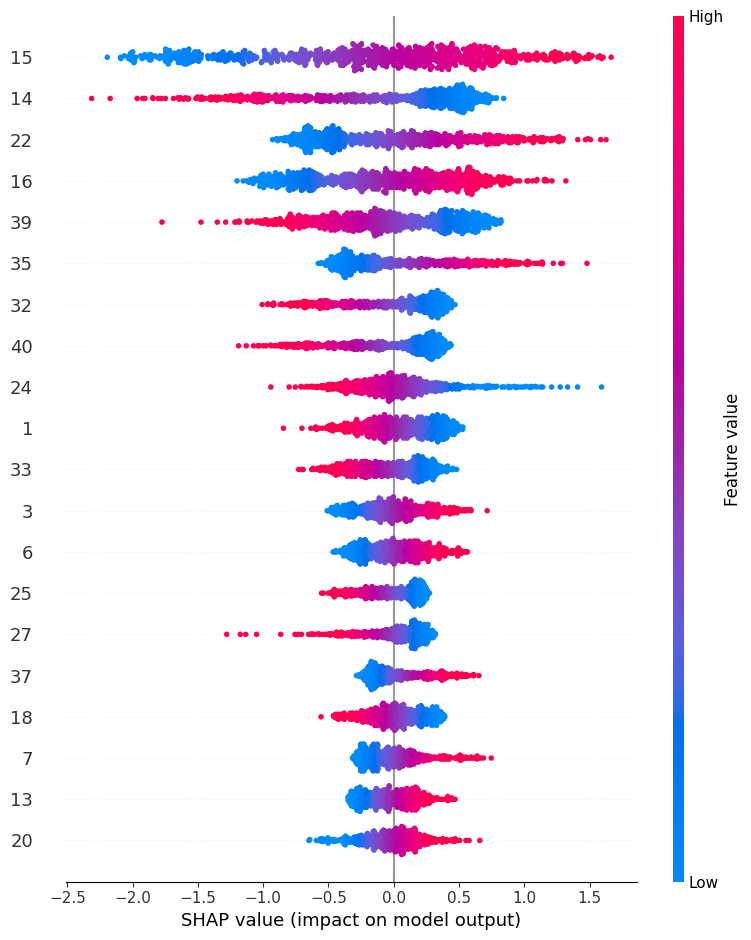

In [5]:
def model_log_odds(x):
	p = model.predict_log_proba(x)
	return p[:,1] - p[:,0]

folds = load_existing_split(folds_pickle)
subtype_csvs_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/subtype_csvs'.format(main_path, dataset, meta_folder)
fold = fold_number
df_all = pd.read_csv('{}/{}_{}_leiden_{}_fold{}.csv'.format(subtype_csvs_path, dataset, type_composition, resolution, fold), index_col=0)
df_all.drop('Meso_type_x', axis=1, inplace=True)
df_all.rename(columns={'Meso_type_y': 'Meso_type'}, inplace=True)

train_fold_samples = folds[fold][0]
val_fold_samples = folds[fold][1]
test_fold_samples = folds[fold][2]
train_df = df_all[df_all['samples'].isin(train_fold_samples)]
test_df = df_all[df_all['samples'].isin(test_fold_samples)]

additional_df = pd.read_csv('{}/{}_{}_leiden_{}_fold{}_additional.csv'.format(subtype_csvs_path, additional_dataset, type_composition, resolution, fold), index_col=0)
additional_df.drop('Meso_type_x', axis=1, inplace=True)
additional_df.rename(columns={'Meso_type_y': 'Meso_type'}, inplace=True)
features = [x for x in df_all.columns.tolist() if x.isdigit()]


train_labels = np.array(train_df[['Meso_type']].values.astype(int).tolist())
train_labels = OneHotEncoder().fit_transform(train_labels.reshape(-1,1)).toarray()
test_labels = np.array(test_df[['Meso_type']].values.astype(int).tolist())
test_labels = OneHotEncoder().fit_transform(test_labels.reshape(-1,1)).toarray()
additional_labels = np.array(additional_df[['Meso_type']].values.astype(int).tolist())
additional_labels = OneHotEncoder().fit_transform(additional_labels.reshape(-1,1)).toarray()



data = [[train_df[features], train_labels], None, [test_df[features], test_labels], [additional_df[features], additional_labels]]
subsampling = 'oversampling'
# Subsampling the imbalance data
# from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE # SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek # SMOTETomek
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler
if subsampling == 'undersampling':
	smt = EditedNearestNeighbours() #undersampling
elif subsampling == 'oversampling':
	smt = SMOTETomek(random_state=42) #oversampling
else:
	smt = None
	raise ValueError('Subsampling method not recognized.')

for df in data:
	if df is not None:
		df[0], df[1] = smt.fit_resample(df[0], df[1])
		df[1] = OneHotEncoder().fit_transform(df[1].reshape(-1, 1)).toarray()


train, valid, test, additional = data
train_data, train_labels = train
train_labels = train_labels[:,1]

test_data, test_labels = test
test_labels = test_labels[:,1]





# a simple linear model
parameters = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1'], 'solver': ['liblinear', 'saga']}
model = sklearn.linear_model.LogisticRegression(max_iter=100000)
clf = sklearn.model_selection.GridSearchCV(model, parameters, cv=5)
# clf.fit(train_df[features], train_df['Meso_type'])
clf.fit(train_data, train_labels)
print(clf.best_params_)

model = sklearn.linear_model.LogisticRegression(penalty=clf.best_params_['penalty'], C=clf.best_params_['C'], solver=clf.best_params_['solver'], max_iter=100000)
# model.fit(train_df[features], train_df['Meso_type'])
model.fit(train_data, train_labels)
# print('auc:', sklearn.metrics.roc_auc_score(test_df['Meso_type'], model.predict_proba(test_df[features])[:,1]))
print('auc:', sklearn.metrics.roc_auc_score(test_labels, model.predict_proba(test_data)[:,1]))

# complete_df = pd.concat([test_df], axis=0)
complete_df = pd.concat([test_data], axis=0)
data_plot = complete_df[features]
data_plot.columns = data_plot.columns.astype(str)

# explainer = shap.Explainer(model_log_odds, test_df[features], max_samples=test_df.shape[0])
explainer = shap.Explainer(model_log_odds, test_data, max_samples=test_data.shape[0])
shap_values = explainer(data_plot)
shap.summary_plot(shap_values)


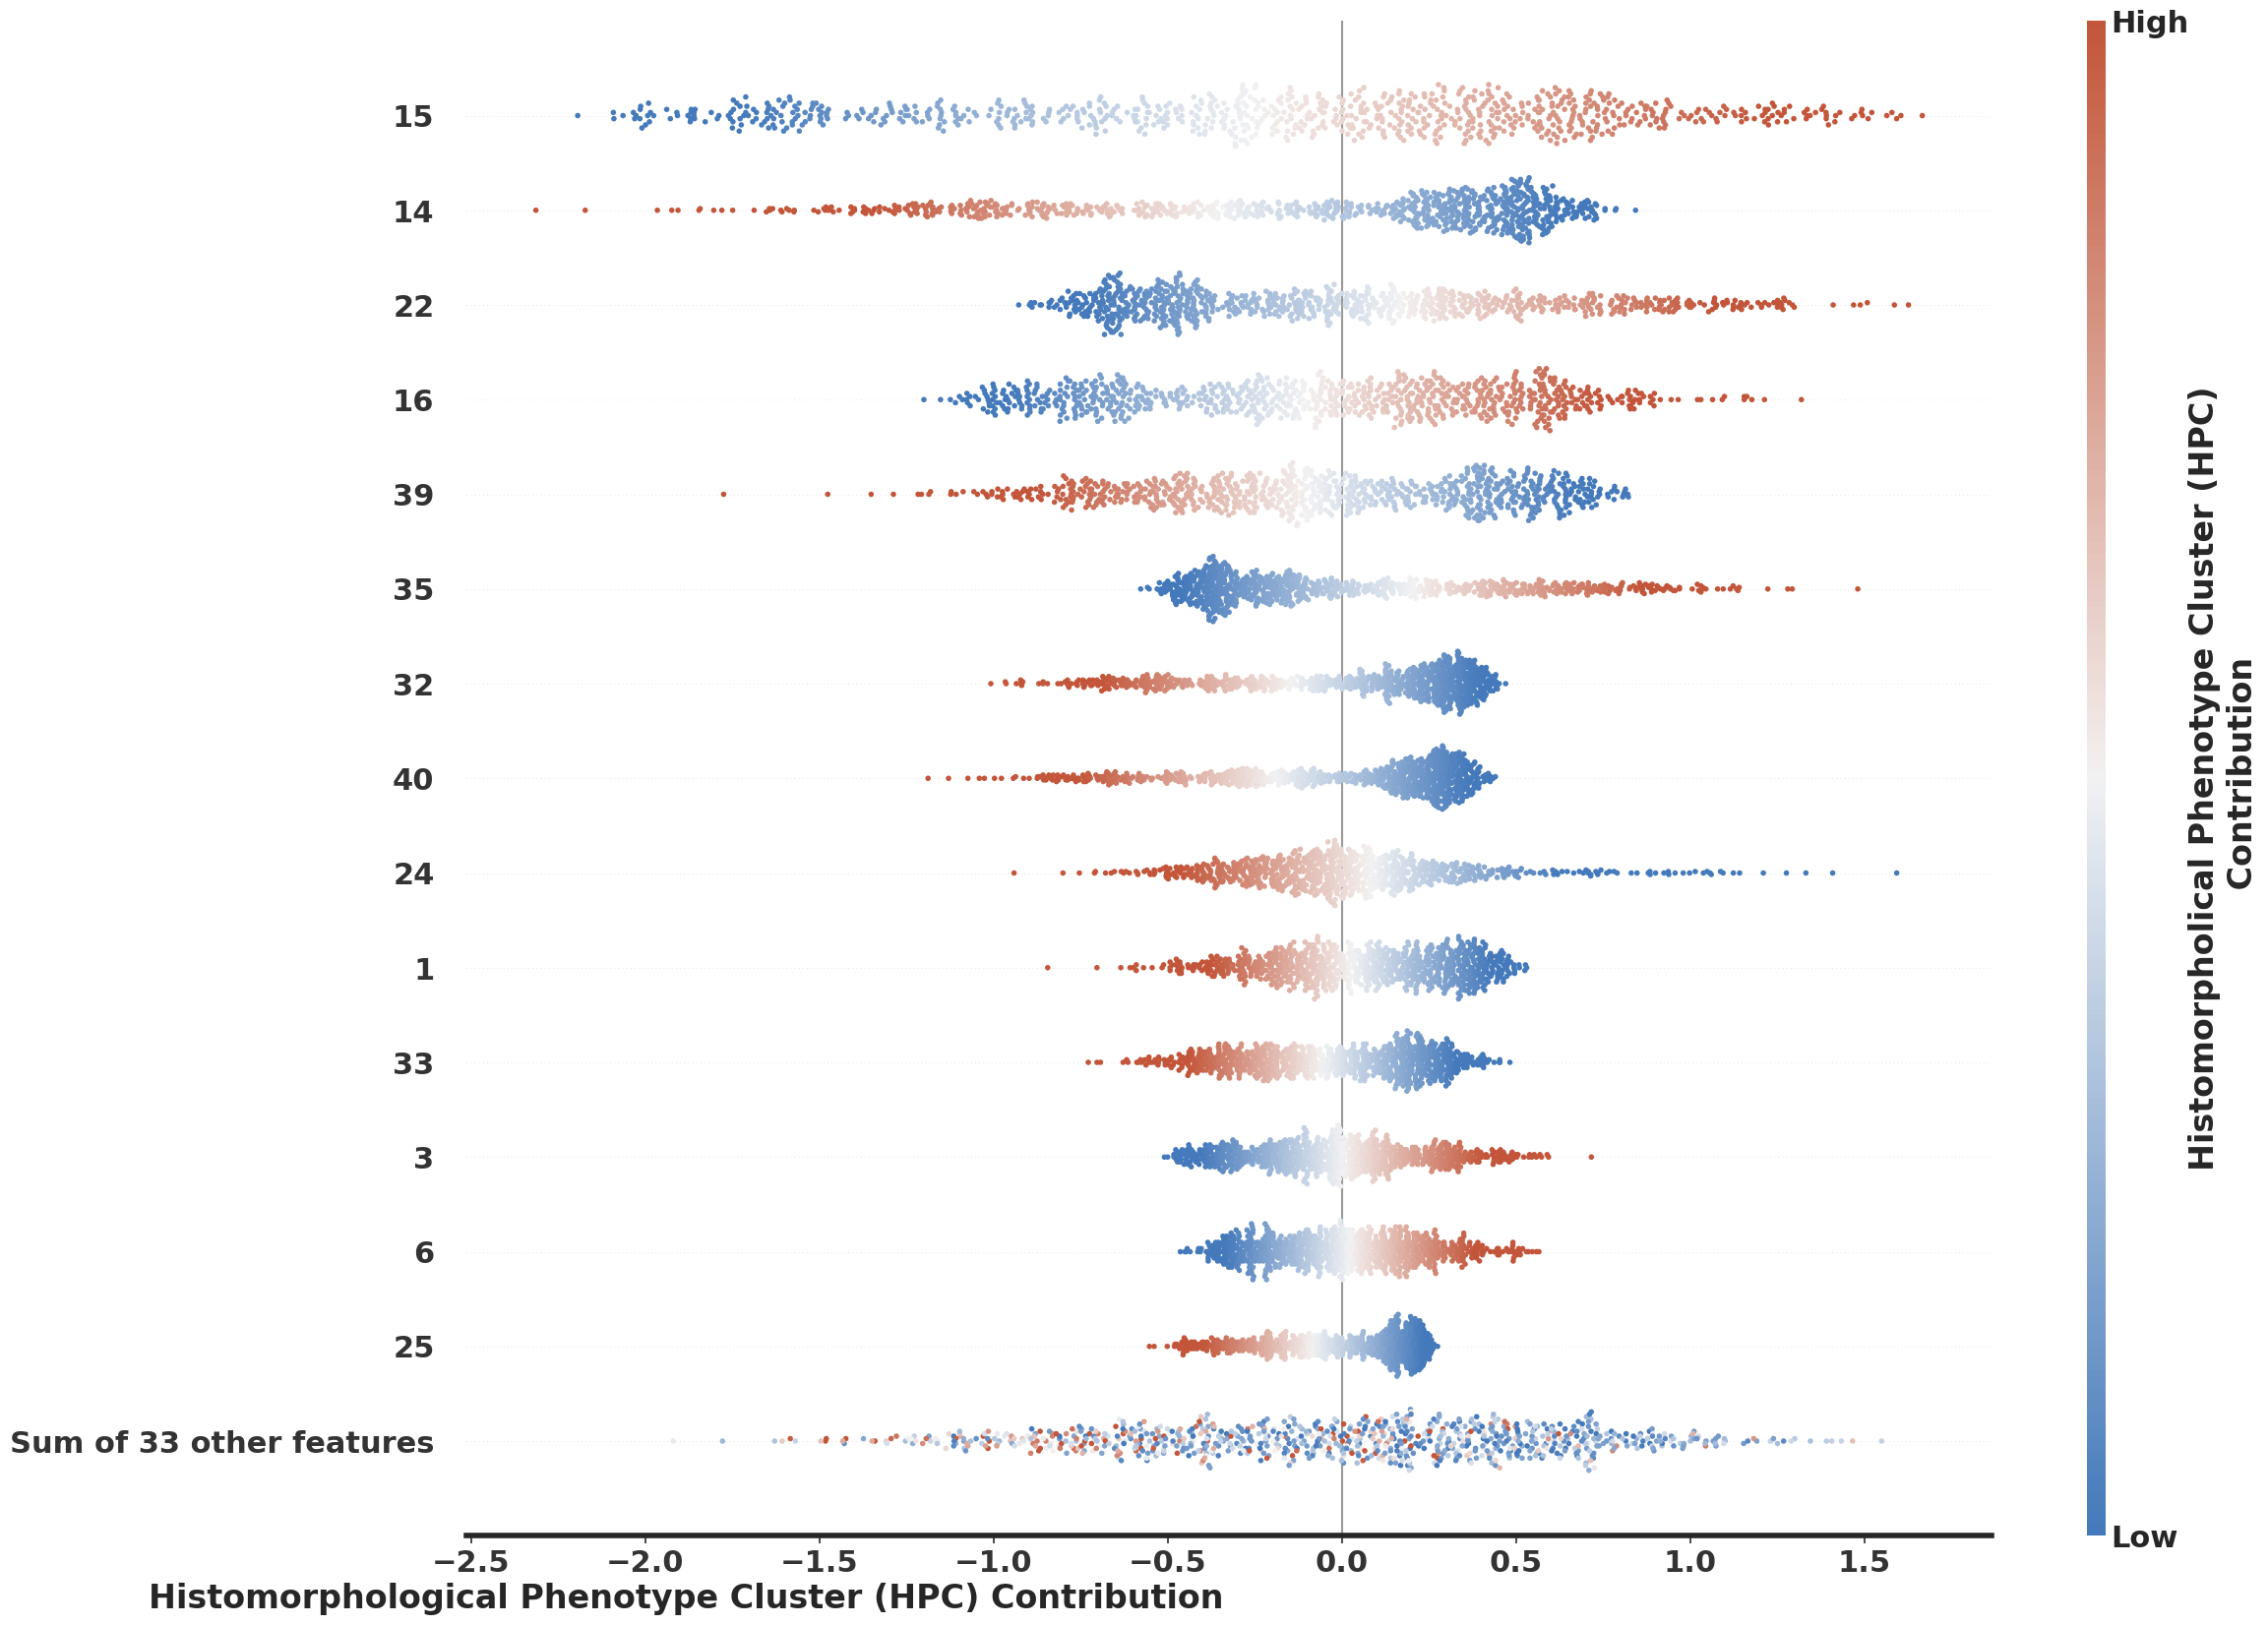

In [7]:
plot_shap_figure_simple(shap_values, text1='Histomorphological Phenotype Cluster (HPC) Contribution', text2='', plot_size=(25,20), fontsize_labels=24, fontsize_ticks=22, offset=150, cmap_bar=sns.diverging_palette(250, 20, as_cmap=True))

# Cox Survival Modeling

In [9]:
# Removing the clusters manually
# leiden 1p5 fold 4
remove_1p5 = [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
hpc_1p5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

# leiden 2p0 fold 4
hpc_2p0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
remove_2p0 = [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 
# back to normal to get the association with all the clusters for the HR plot
remove_2p0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# leiden 2p5 fold 4
hpc_2p5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
remove_2p5 = [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

# leiden 3p0 fold 4
hpc_3p0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
remove_3p0 = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# leiden 4p0 fold 4
hpc_4p0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
remove_4p0 = [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

dict_removal = {'1p5':[remove_1p5, hpc_1p5], '2p0':[remove_2p0, hpc_2p0], '2p5':[remove_2p5, hpc_2p5], '3p0':[remove_3p0, hpc_3p0], '4p0':[remove_4p0, hpc_4p0]}


event_ind_field = 'os_event_ind'
event_data_field = 'os_event_data'
resolution = '2p0'
groupby        = 'leiden_%s' % resolution
fold_number = 4


# For Kaplan-Meier Plots
matching_field = 'case_Id'
num_folds = 5
dataset = 'Meso'
meta_folder = '750K'

In [28]:
penalizer = .5
l1_ratio = .1
sns.set_theme(style="whitegrid")
# resolutions = ['1p5', '2p0', '2p5', '3p0', '4p0']
cis_list = []
fold = fold_number
train_risk = [pd.DataFrame(), pd.DataFrame()]
test_risk = [pd.DataFrame(), pd.DataFrame()]
additional_risk = [pd.DataFrame(), pd.DataFrame()]

train = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_train_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)

test = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_test_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)

additional = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_additional_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)


# remove this column from the train and test data
leiden_clusters = []
hpc, remove = dict_removal[resolution][1], dict_removal[resolution][0]
for cluster, removal in zip(hpc, remove):
        if not removal: leiden_clusters.append(str(cluster))

train_df = train[leiden_clusters + [event_data_field, event_ind_field]]
test_df = test[leiden_clusters + [event_data_field, event_ind_field]]
additional_df = additional[leiden_clusters + [event_data_field, event_ind_field]]
features = [x for x in train_df.columns.tolist() if x.isdigit()]
leiden_clusters = [str(x) for x in features]

cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
cph.fit(train_df, duration_col=event_data_field, event_col=event_ind_field, robust=True)
cis_list.append(cph.score(train_df, scoring_method='concordance_index'))
cis_list.append(cph.score(test_df, scoring_method='concordance_index'))
cis_list.append(cph.score(additional_df, scoring_method='concordance_index'))

train_df = train[leiden_clusters + [event_data_field, event_ind_field, matching_field]]
test_df = test[leiden_clusters + [event_data_field, event_ind_field, matching_field]]
additional_df = additional[leiden_clusters + [event_data_field, event_ind_field, matching_field]]

datas = [(train_df, 'train'), (test_df, 'test'), (additional_df, 'additional')]

train_preds = cph.predict_partial_hazard(train_df)
test_preds = cph.predict_partial_hazard(test_df)
additional_preds = cph.predict_partial_hazard(additional_df)

predictions = [(train_preds,'train'), (test_preds,'test'), (additional_preds,'additional')]

explainer = shap.Explainer(cph.predict_log_partial_hazard, train[features], max_samples=train.shape[0])
complete_df = pd.concat([test, train], axis=0)
shap_values = explainer(complete_df[features])


high_lows = get_high_low_risks(predictions, datas, fold, matching_field, q_buckets=2)

# train_risk, test_risk, additional_risk = combine_risk_groups(train_risk, test_risk, additional_risk, high_lows, fold, num_folds, matching_field, event_ind_field, event_data_field)





PermutationExplainer explainer: 487it [00:21, 11.37it/s]                         


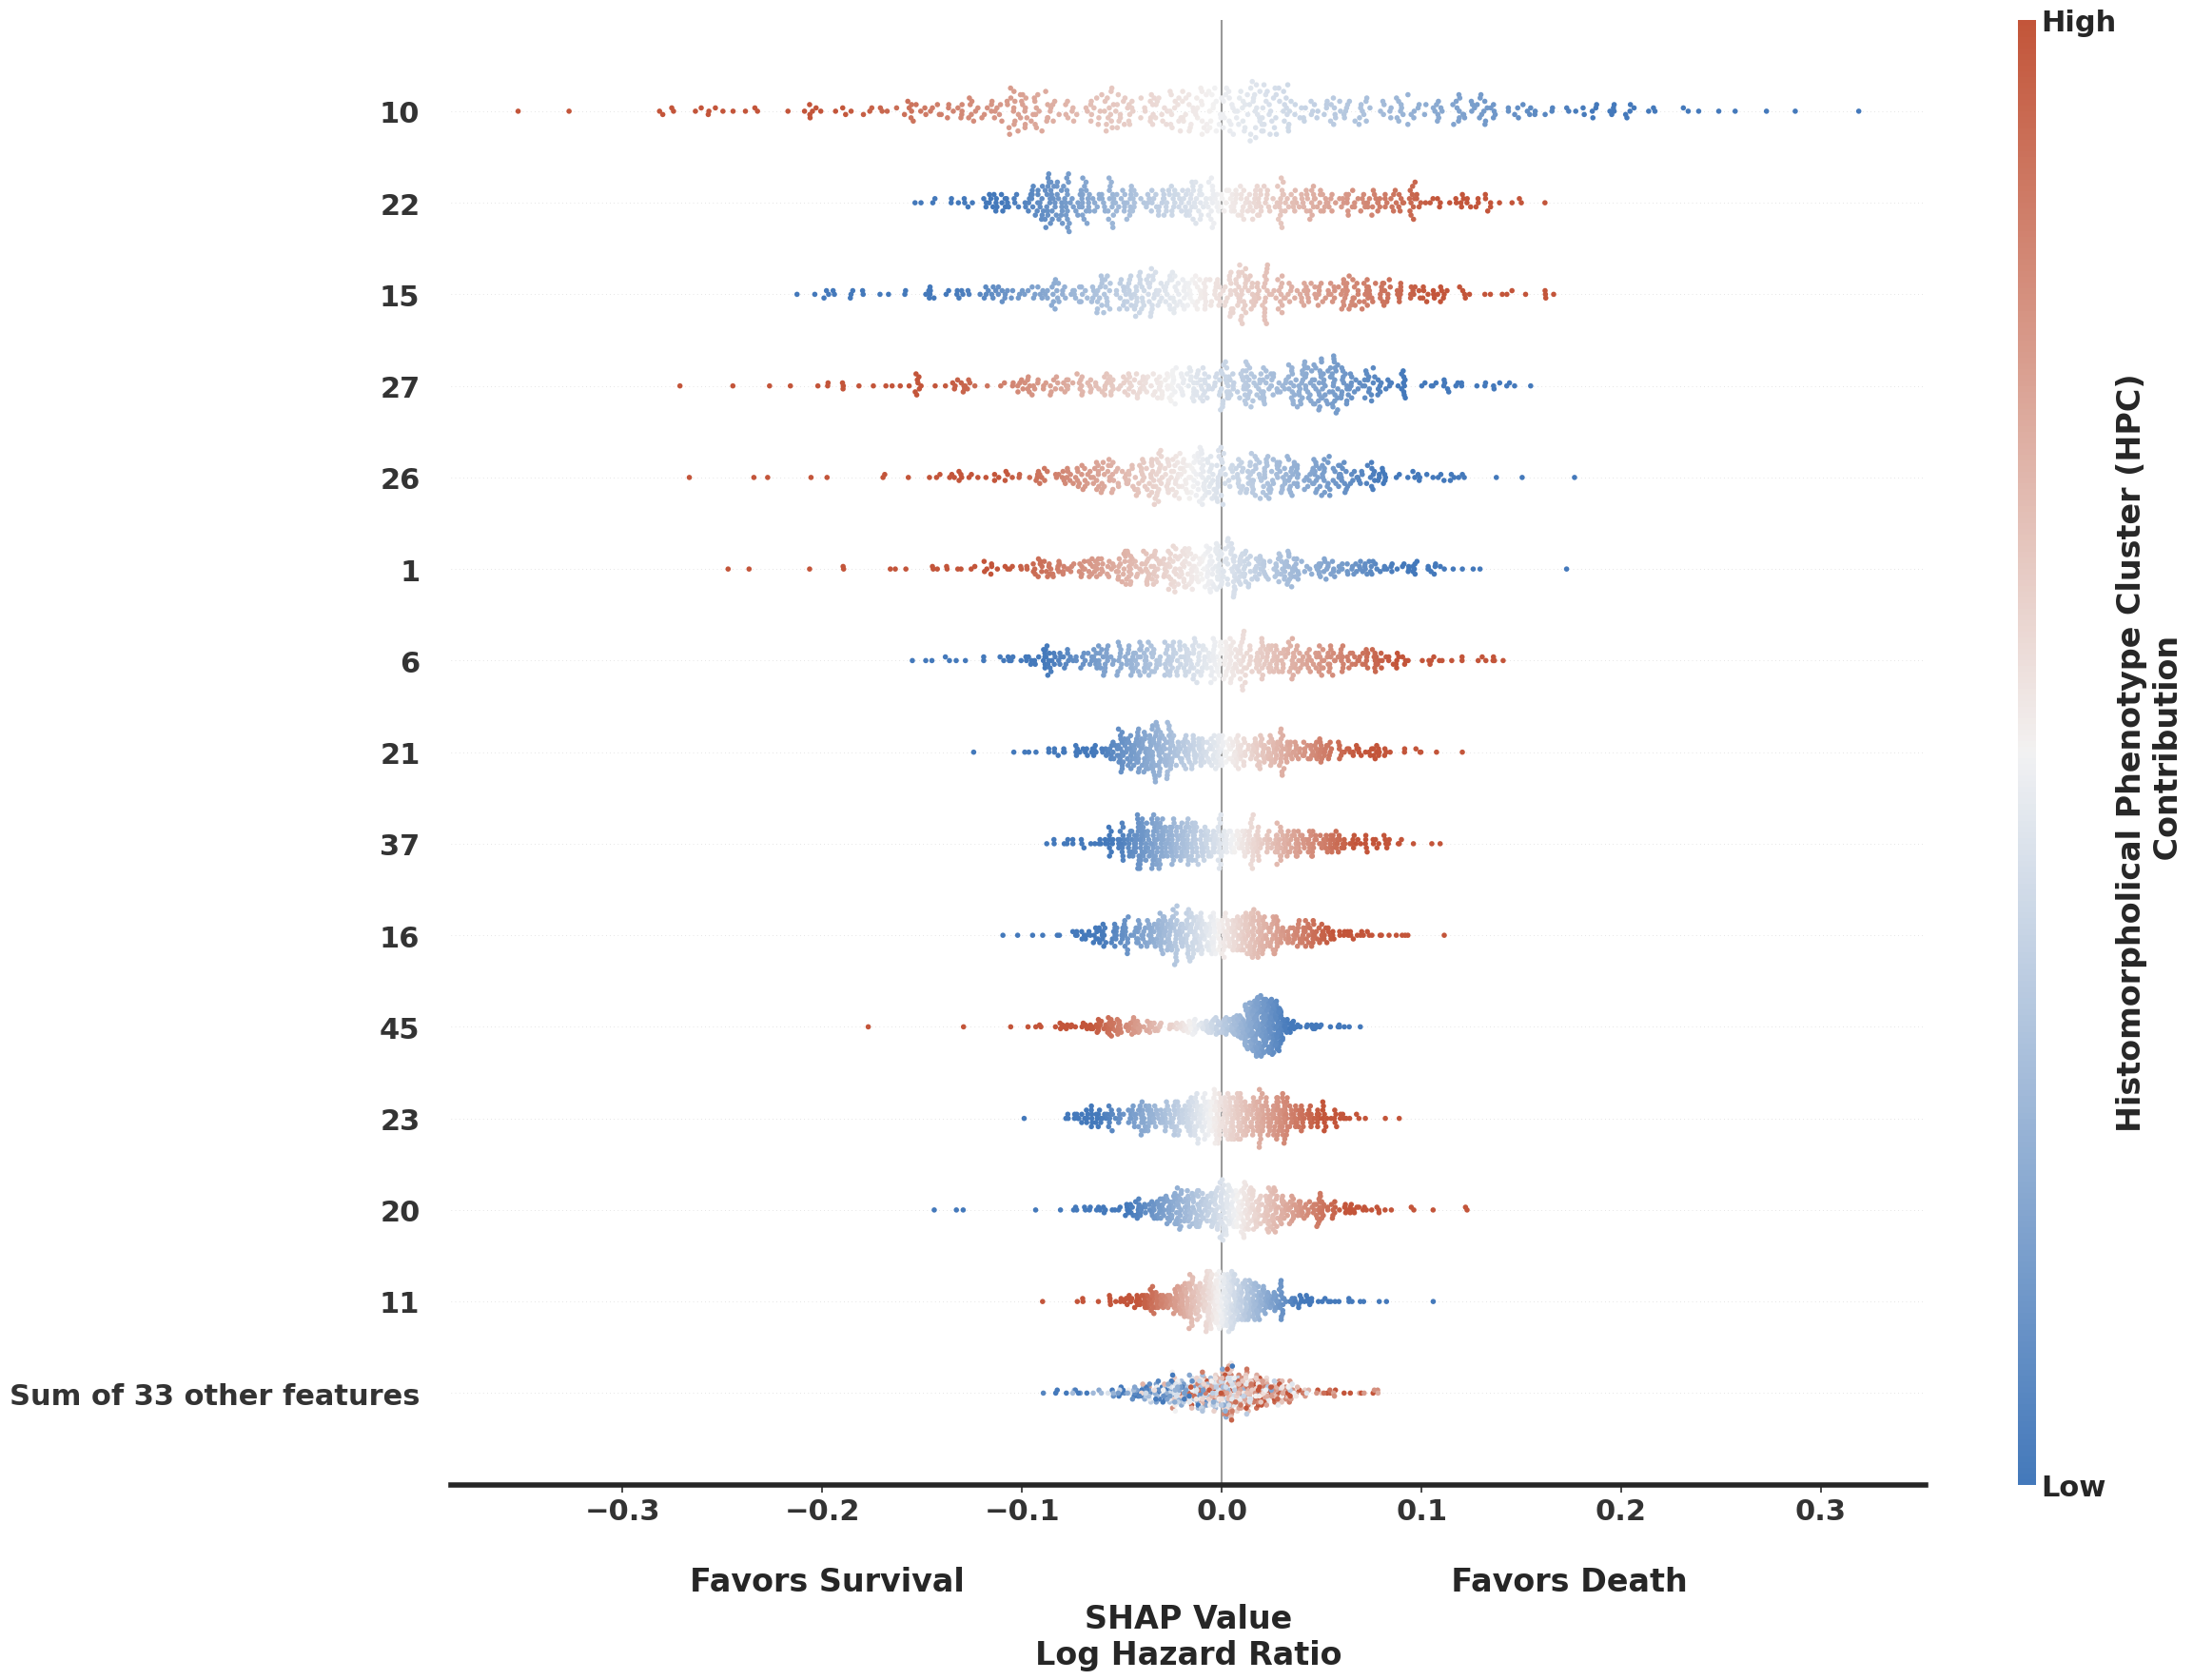

In [12]:
text1 = '\nFavors Survival'
text2 = 'Favors Death\nSHAP Value\nLog Hazard Ratio'
plot_shap_figure_simple(shap_values, offset=100, text1=text1,text2=text2, cmap_bar=sns.diverging_palette(250, 20, as_cmap=True))

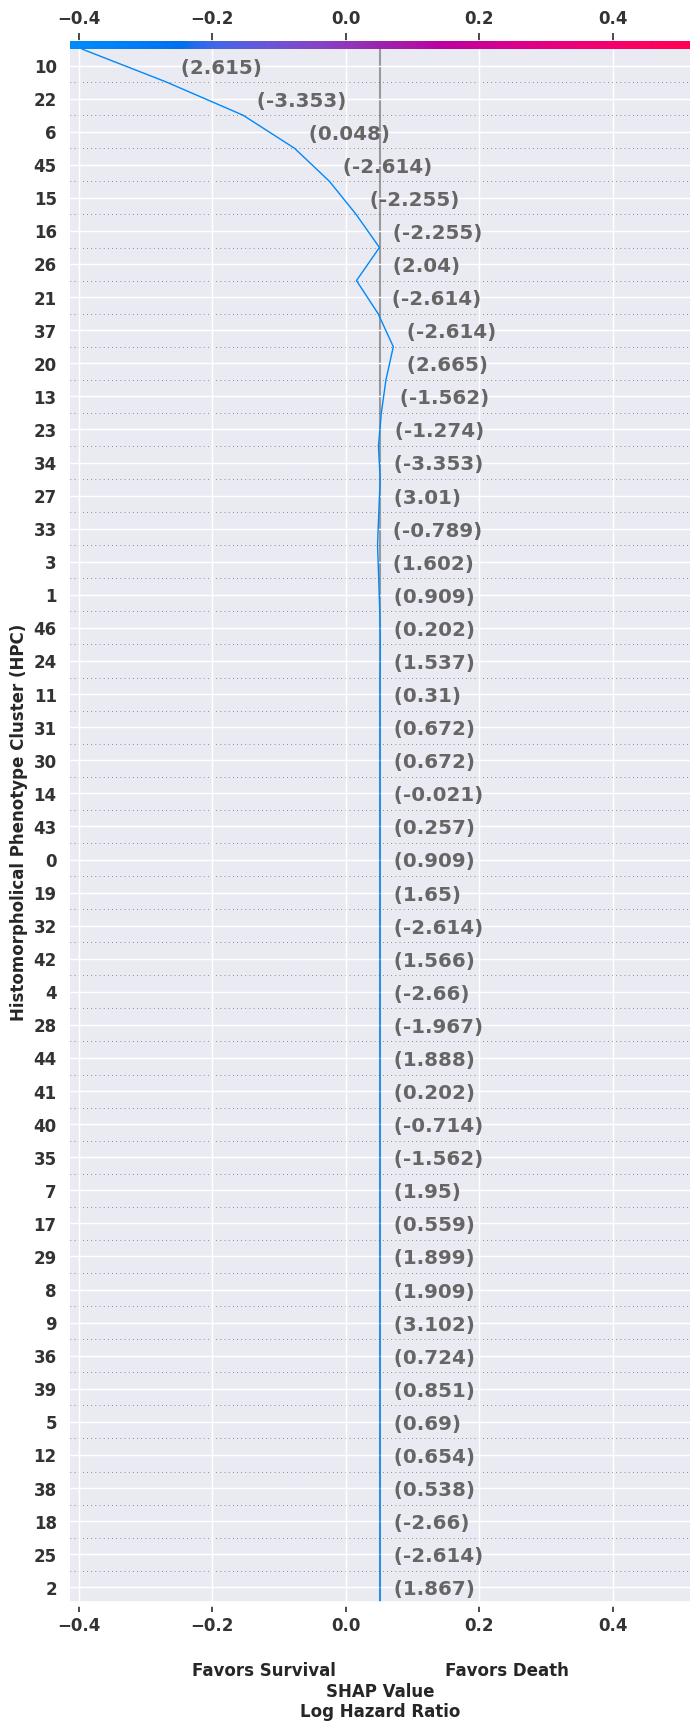

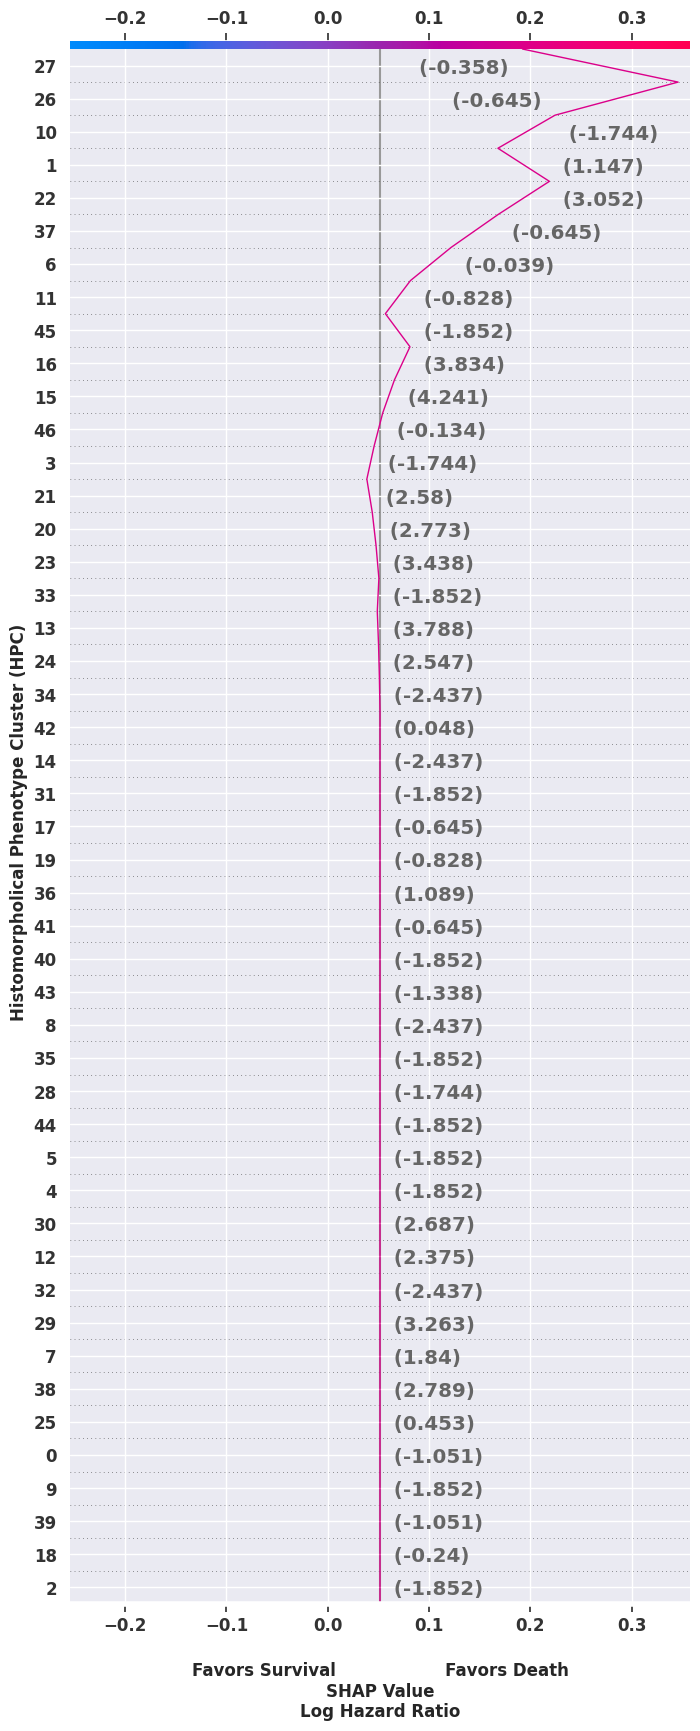

In [84]:
# Shap figure.
sns.set_theme(palette='flare')
sns.set_palette('flare')
num_features    = 'all'
# num_features    = 5
# num_samples     = 10
fontsize_labels = 12
fontsize_ticks  = 12
fontsize_legend = 8
l_box_w         = 3
offset=75
show_legend = True

# Shap figure.
text1 = '\nFavors Survival'
text2 = 'Favors Death\nSHAP Value\nLog Hazard Ratio'
text = text1 + ''.join([' ']*(offset-len(text1+text2))) + text2
low_risk_df, high_risk_df, complete = high_lows[0][1], high_lows[0][0], pd.concat([test, train], axis=0)
low_risk_df, high_risk_df = low_risk_df.sort_values(by='hazard'), high_risk_df.sort_values(by='hazard')

# lowest risk
xlim = plot_shap_decision(shap_values.base_values, shap_values.values, complete[features], low_risk_df.index[0:1], None ,num_features, show_legend, text, fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w)
# highest risk
xlim = plot_shap_decision(shap_values.base_values, shap_values.values, complete[features], None, high_risk_df.index[-1:] ,num_features, show_legend, text, fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w)


## C-Index Performance

## Shap figures

In [ ]:
def remove_features_from_shap(shap_cv, features_to_remove):
	shap_cv_removed = copy.deepcopy(shap_cv)
	for feature in features_to_remove:
		shap_cv_removed.values[:,feature] = 0
		shap_cv_removed.data[:,feature] = 0
	return shap_cv_removed

for hpc_samples in [20, 10]:
	# Get order to display:
	# 1. Pro/Against event: Cox coefficient sign.
	# 2. Average absolute effect on the cohort: SHAP.
	# Select top X HPC impact for Pro/Against.
	hpc_impact = list(reversed(np.argsort(shap_cv.abs.mean(0).values)))
	pos_order = list()
	neg_order = list()
	for hpc in hpc_impact:
		if hpc in hpc_pos and len(pos_order+neg_order) < hpc_samples:
			pos_order.append(hpc)
		elif hpc in hpc_neg and len(pos_order+neg_order) < hpc_samples:
			neg_order.append(hpc)
	order = pos_order + list(reversed(neg_order))
	difference = list(set(features).difference(set(order)))
	total_order = order + list(difference)

	# Remove the features that are not going to be plotted for ascetics.
	shap_cv_removed = remove_features_from_shap(shap_cv=shap_cv, features_to_remove=difference)

	# Shap figure.
	if 'os_' in event_ind_field:
		text1 = '\nFavors Survival'
		text2 = 'Favors Death\nSHAP Value\nLog Hazard Ratio'
	else:
		text1 = '\nAgainst Recurrence'
		text2 = 'Favors Recurrence\nSHAP Value\nLog Hazard Ratio'

	fontsize_labels = 34
	fontsize_ticks  = 34
	plot_shap_figure(shap_cv_removed, order, total_order, text1, text2, plot_size=(25,20), fontsize_labels=fontsize_labels, fontsize_ticks=fontsize_ticks, 
					 offset=100, cmap_bar=sns.diverging_palette(250, 20, as_cmap=True))

In [ ]:
data_df_perc = pd.concat([datas_all_percent[0][0], datas_all_percent[2][0]])
data_df_perc.columns = data_df_perc.columns.astype(str)
if data_df_perc.shape[0]!=dataset_samples.shape[0]:
    print('Error number of samples does not match.')

data_df_perc = data_df_perc.set_index('samples')
data_df_perc = data_df_perc.reindex(dataset_samples.samples.tolist())
data_df_perc = data_df_perc.reset_index()

num_features    = 'all'
# num_features    = 15
num_samples     = 10
fontsize_labels = 20
fontsize_ticks  = 18
fontsize_legend = 16
l_box_w         = 3
offset=75
show_legend = True

# Shap figure.
text1 = '\nFavors Survival'
text2 = 'Favors Death\nSHAP Value\nLog Hazard Ratio'
text = text1 + ''.join([' ']*(offset-len(text1+text2))) + text2

low_risk = risk_groups[0]
sample_low_risk = low_risk.sort_values(by=['hazard']).iloc[:num_samples]['samples']
low_risk_ind = dataset_samples[dataset_samples[matching_field].isin(sample_low_risk)].index
data_df_perc_sample = data_df_perc[data_df_perc[matching_field].isin(sample_low_risk)]

high_risk = risk_groups[1]
sample_high_risk = high_risk.sort_values(by=['hazard'], ascending=False).iloc[:num_samples]['samples']
high_risk_ind = dataset_samples[dataset_samples[matching_field].isin(sample_high_risk)].index
data_df_perc_sample = data_df_perc[data_df_perc[matching_field].isin(sample_high_risk)]

shap_base_values         = shap_cv.base_values
shap_values              = shap_cv.values
dataset_samples_features = dataset_samples[leiden_clusters.astype(str)]

xlim = plot_shap_decision(shap_values.base_values, shap_values.values, compl, low_risk_ind, high_risk_ind, num_features, show_legend, text, fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w)


In [ ]:
show_legend = True
num_samples = 47

# ascending = False
# match = 0
# name_plot = 'censored_long_followup'

ascending = True
match = 1
name_plot = 'event_short_time'

dataset_samples_copy = dataset_samples.sort_values(by=event_data_field, ascending=ascending).copy(deep=True)
dataset_samples_copy = dataset_samples_copy[dataset_samples_copy[event_ind_field]==match]
samples_to_get       = dataset_samples_copy.iloc[:num_samples]['samples']

low_risk = risk_groups[0]
low_risk        = low_risk[low_risk[matching_field].isin(samples_to_get)]
sample_low_risk = low_risk.sort_values(by=['hazard']).iloc[:num_samples]['samples']
low_risk_ind = dataset_samples[dataset_samples[matching_field].isin(sample_low_risk)].index
data_df_perc_sample = data_df_perc[data_df_perc[matching_field].isin(sample_low_risk)]

high_risk = risk_groups[1]
high_risk        = high_risk[high_risk[matching_field].isin(samples_to_get)]
sample_high_risk = high_risk.sort_values(by=['hazard'], ascending=False).iloc[:num_samples]['samples']
high_risk_ind = dataset_samples[dataset_samples[matching_field].isin(sample_high_risk)].index
data_df_perc_sample = data_df_perc[data_df_perc[matching_field].isin(sample_high_risk)]

shap_base_values         = shap_cv.base_values
shap_values              = shap_cv.values
dataset_samples_features = dataset_samples[leiden_clusters.astype(str)]

plot_shap_decision(shap_base_values, shap_values, dataset_samples_features, low_risk_ind, high_risk_ind, num_features, show_legend, text, fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w, xlim)
dataset_samples_copy[dataset_samples_copy[matching_field].isin(samples_to_get)]

In [ ]:
combined_df = pd.DataFrame()
for hpc in leiden_clusters.astype(str):
    hpc_list = list()
    for line_a, line_b in zip(dataset_samples[hpc].values, data_df_perc[hpc].values):
        line = str(np.round(line_a,3)) + ' / ' + str(np.round(line_b*100,2))
        hpc_list.append(line)
    combined_df[hpc] = hpc_list
combined_df.columns = leiden_clusters.astype(str)
combined_df = combined_df.set_index(dataset_samples.index)
combined_df.head(5)

In [ ]:
def plot_shap_decision_ind(shap_base_values, shap_values, dataset_samples_features, leiden_clusters, low_risk_ind, high_risk_ind, num_features, show_legend, text, fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w, xlim=None, annotation=False, y_perc=False):

    if low_risk_ind is None:
        risk_ind = high_risk_ind
    elif high_risk_ind is None:
        risk_ind = low_risk_ind
    else:
        risk_ind = np.concatenate([low_risk_ind.values, high_risk_ind.values])

    # Legend handling.
    if show_legend:
        legend_labels = ['Low Risk' for s in range(low_risk_ind.values.shape[0])]
        legend_labels.extend(['High Risk' for s in range(high_risk_ind.values.shape[0])])
    else:
        legend_labels = None
    # Number of HPCs to display
    if num_features == 'all':
        feature_display_range = slice(None, None, -1)
    else:
        feature_display_range = slice(-1, -num_features, -1)

    shap_base_plot = [shap_base_values[risk_ind[0]]]
    shap_cv_values = np.array(shap_cv.values[risk_ind[0]].reshape((1,-1)))
    data_values    = np.array(dataset_samples_features.loc[risk_ind[0]].values.reshape((1,-1)))

    for ind in risk_ind[1:]:        
        shap_base_plot.append(shap_base_values[ind])
        shap_cv_values = np.concatenate([shap_cv_values, shap_cv.values[ind].reshape((1,-1))])
        data_values    = np.concatenate([data_values, dataset_samples_features.loc[ind].values.reshape((1,-1))])

    # SHAP decision plot.
    if not annotation:
        shap.decision_plot(base_value=np.mean(shap_base_plot), shap_values=shap_cv_values, feature_names=leiden_clusters.astype(str), xlim=xlim,
                        feature_order='importance', feature_display_range=feature_display_range, show=False, legend_labels=legend_labels, legend_location='lower right')
    else:
        shap.decision_plot(base_value=np.mean(shap_base_plot), shap_values=shap_cv_values, features=dataset_samples_features.loc[risk_ind], xlim=xlim,
                        feature_order='importance', feature_display_range=feature_display_range, show=False, legend_labels=legend_labels, legend_location='lower right')
    # shap.decision_plot(base_value=np.mean(shap_base_plot), shap_values=shap_cv_values, xlim=xlim,
                    # feature_order='importance', feature_display_range=feature_display_range, show=False, legend_labels=legend_labels, legend_location='lower right')

    # Ascetic fixes.
    figure = plt.gcf()
    figure.axes[0].set_xlabel(text, fontweight='bold', fontsize=fontsize_labels)
    if y_perc:
        figure.axes[0].set_ylabel('HPC Percentage', fontweight='bold', fontsize=fontsize_labels)
    else:
        figure.axes[0].set_ylabel('Histomorpholical Phenotype Cluster (HPC)', fontweight='bold', fontsize=fontsize_labels)

    if y_perc:
        yticklabels = list()
        for label_tick in figure.axes[0].get_yticklabels():
            hpc = label_tick._text
            anno = dataset_samples_features.loc[risk_ind, hpc].values[0]
            yticklabels.append(str(anno).split('/')[1]+'%')
        # plot.set_xticks([mini, self.center, maxi], fontsize=fontsize)
        figure.axes[0].set_yticklabels(yticklabels)
    for ax in [figure.axes[0]]:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontweight('bold')
            tick.label2.set_fontweight('bold')
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label2.set_fontsize(fontsize_ticks)            
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontweight('bold')
            tick.label2.set_fontweight('bold')
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label2.set_fontsize(fontsize_ticks)
            # if fontscale_anno == 0.0:
            # print(tick.label1)
            # print(tick.label2)
        for axis in ['bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
    
    # Legend for High/Low risk group.
    if show_legend:
        legend = figure.axes[0].legend_
        new_handles = [legend.legendHandles[0], legend.legendHandles[-1]]
        new_texts   = [legend.get_texts()[0]._text, legend.get_texts()[-1]._text]
        map_dict = dict()
        for handle, text in zip(legend.legendHandles, legend.get_texts()):
            map_dict[handle._label] = text._text

        legend.remove()
        legend = figure.axes[0].legend(new_handles, new_texts, loc='lower right')
        legend.get_frame().set_linewidth(l_box_w)
        for i, handler in enumerate(legend.legendHandles):
            handler.set_linewidth(5)
            handler.set_color('Blue')
            if i!=0:
                handler.set_color('Red')

        for text in legend.get_texts():
            text.set_size(fontsize_legend)
            text.set_fontweight('bold')

        # Re-color lines for High/Low risk group.
        continuous_lines = [child for child in figure.axes[0]._children if child._linestyle == '-' and len(child._x) > 2]
        i = 0 
        for child in continuous_lines:
            risk_name = map_dict[child._label]
            if risk_name == 'Low Risk':
                child.set_color('Blue')
            elif risk_name == 'High Risk':
                child.set_color('Red')
            i+=1
    else:
        annotations_val  = [child for child in figure.axes[0]._children if not isinstance(child, matplotlib.lines.Line2D)]
        for child in annotations_val:
            orig_fontsize = child._fontproperties._size
            child.set_fontweight('bold')
            child.set_size(orig_fontsize*1.1)

    plt.show()

    global_xlim = figure.axes[0].get_xlim()
    return global_xlim

In [ ]:
high_risk = risk_groups[1]
high_risk = high_risk[high_risk.h_bin==1]
sample_high_risk = high_risk.sort_values(by=['hazard'], ascending=False).iloc[[1]]['samples']
high_risk_ind = dataset_samples[dataset_samples[matching_field].isin(sample_high_risk)].index
dataset_samples[dataset_samples[matching_field].isin(sample_high_risk)]


In [ ]:
show_legend = False

low_risk = risk_groups[0]
low_risk = low_risk[low_risk.h_bin==0]
sample_low_risk = low_risk.sort_values(by=['hazard']).iloc[0]['samples']
low_risk_ind = dataset_samples[dataset_samples[matching_field].isin([sample_low_risk])].index

high_risk = risk_groups[1]
high_risk = high_risk[high_risk.h_bin==1]
sample_high_risk = high_risk.sort_values(by=['hazard'], ascending=False).iloc[[1]]['samples']
high_risk_ind = dataset_samples[dataset_samples[matching_field].isin(sample_high_risk)].index

for l_ind, h_ind in [(low_risk_ind, None), (None, high_risk_ind)]:
    # for values_to_use in [combined_df, data_df_perc, dataset_samples]:
    for values_to_use in [combined_df]:

        shap_base_values         = shap_cv.base_values
        shap_values              = shap_cv.values
        dataset_samples_features = values_to_use[leiden_clusters.astype(str)]

        plot_shap_decision_ind(shap_base_values, shap_values, dataset_samples_features, leiden_clusters, l_ind, h_ind, num_features, show_legend, text, 
                               fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w, xlim, annotation=False, y_perc=False)
        plot_shap_decision_ind(shap_base_values, shap_values, dataset_samples_features, leiden_clusters, l_ind, h_ind, num_features, show_legend, text, 
                               fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w, xlim, annotation=False, y_perc=True)


In [90]:
from skbio.stats.composition import clr, ilr, alr, multiplicative_replacement

from scipy.stats.mstats import gmean

for ind in [0,1,2,3]:
    
    sample_low_risk = low_risk_df.sort_values(by=['hazard']).iloc[[ind]]['case_Id']
    sample_high_risk = high_risk_df.sort_values(by=['hazard'], ascending=False).iloc[[ind]]['case_Id']

    original_rep_h = complete[complete[matching_field].isin(sample_high_risk)][leiden_clusters].values[0,:].tolist()
    multrepl_rep_h = multiplicative_replacement(np.reshape(original_rep_h, (1,-1)))
    clr_rep_h      = clr(np.reshape(multrepl_rep_h, (1,-1)))

    delta_h = np.round(1/(multrepl_rep_h.shape[0]*multrepl_rep_h.shape[0]), 4)
    g_x_h   = np.round(gmean(multrepl_rep_h), 4)

    original_rep_l = data_df_perc[data_df_perc[matching_field].isin(sample_low_risk)][leiden_clusters.astype(str)].values[0,:].tolist()
    multrepl_rep_l = multiplicative_replacement(np.reshape(original_rep_l, (1,-1)))
    clr_rep_l      = clr(np.reshape(multrepl_rep_l, (1,-1)))

    delta_l = np.round(1/(multrepl_rep_l.shape[0]*multrepl_rep_l.shape[0]),4)
    g_x_l   = np.round(gmean(multrepl_rep_l), 4)


    fig   = plt.figure(figsize=(30,17))

    ax    = fig.add_subplot(3, 2, 1)
    ax.set_title('%s - High Risk\nCompositional Data Original' % sample_high_risk.values[0])
    ax.bar(x=leiden_clusters.tolist(), height=original_rep_h, tick_label=leiden_clusters)
    ax.set_ylim([0.0,0.9])
    ax    = fig.add_subplot(3, 2, 2)
    ax.set_title('%s - Low Risk\nCompositional Data Original' % sample_low_risk.values[0])
    ax.bar(x=leiden_clusters.tolist(), height=original_rep_l, tick_label=leiden_clusters)
    ax.set_ylim([0.0,0.9])

    ax    = fig.add_subplot(3, 2, 3)
    ax.set_title('Compositional Data Multiplicative Replacement\ndelta=1/N^2=%s' % delta_h)
    ax.bar(x=leiden_clusters.tolist(), height=multrepl_rep_h, tick_label=leiden_clusters)
    ax.set_ylim([0.0,0.9])
    ax    = fig.add_subplot(3, 2, 4)
    ax.set_title('Compositional Data Multiplicative Replacement\ndelta=1/N^2=%s' % delta_l)
    ax.bar(x=leiden_clusters.tolist(), height=multrepl_rep_l, tick_label=leiden_clusters)
    ax.set_ylim([0.0,0.9])

    ax    = fig.add_subplot(3, 2, 5)
    ax.set_title('Euclidean Data Centered Log Ratio\ng(x)=%s' % g_x_h)
    ax.bar(x=leiden_clusters.tolist(), height=clr_rep_h, tick_label=leiden_clusters)
    ax.set_ylim([-2.5,7])
    ax    = fig.add_subplot(3, 2, 6)
    ax.set_title('Euclidean Data Centered Log Ratio\ng(x)=%s' % g_x_l)
    ax.bar(x=leiden_clusters.tolist(), height=clr_rep_l, tick_label=leiden_clusters)
    ax.set_ylim([-2.5,7])

    plt.show()

ValueError: Cannot have negative proportions